# Generic dfs processing
Tools and methods that applies to any type of dfs files. 

* mikeio.read()
* mikeio.generic: methods that read any dfs file and outputs a new dfs file of the same type
   - concat: Concatenates files along the time axis  
   - scale: Apply scaling to any dfs file
   - sum: Sum two dfs files 
   - diff: Calculate difference between two dfs files
   - extract: Extract timesteps and/or items to a new dfs file


## Concatenation

In [1]:
import matplotlib.pyplot as plt
import mikeio

Take a look at these two files with overlapping timesteps.

In [2]:
t1 = mikeio.read("../tests/testdata/tide1.dfs1")
t1

100%|██████████| 97/97 [00:00<00:00, 5705.74it/s]


<mikeio.Dataset>
Dimensions: (97, 10)
Time: 2019-01-01 00:00:00 - 2019-01-03 00:00:00
Items:
  0:  Level <Water Level> (meter)

In [3]:
t2 = mikeio.read("../tests/testdata/tide2.dfs1")
t2

100%|██████████| 97/97 [00:00<00:00, 24253.20it/s]


<mikeio.Dataset>
Dimensions: (97, 10)
Time: 2019-01-02 00:00:00 - 2019-01-04 00:00:00
Items:
  0:  Level <Water Level> (meter)

Plot one of the points along the line.

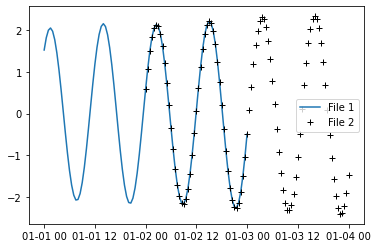

In [4]:
plt.plot(t1.time,t1.data[0][:,1], label="File 1")
plt.plot(t2.time,t2.data[0][:,1],'k+', label="File 2")
plt.legend()

In [5]:
import mikeio.generic

mikeio.generic.concat(infilenames=["../tests/testdata/tide1.dfs1",
                                   "../tests/testdata/tide2.dfs1"],
                     outfilename="concat.dfs1")

100%|██████████| 2/2 [00:00<00:00, 111.11it/s]


100%|██████████| 145/145 [00:00<00:00, 18120.37it/s]


<mikeio.Dataset>
Dimensions: (145, 10)
Time: 2019-01-01 00:00:00 - 2019-01-04 00:00:00
Items:
  0:  Level <Water Level> (meter)

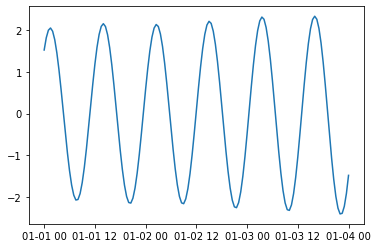

In [6]:
c = mikeio.read("concat.dfs1")
plt.plot(c.time,c.data[0][:,1])
c

## Extract time steps or items

In [7]:
infile = "../tests/testdata/tide1.dfs1"
mikeio.generic.extract(infile, "extracted.dfs1", start='2019-01-02')

In [8]:
e = mikeio.read("extracted.dfs1")
e

100%|██████████| 49/49 [00:00<00:00, 24504.70it/s]


<mikeio.Dataset>
Dimensions: (49, 10)
Time: 2019-01-02 00:00:00 - 2019-01-03 00:00:00
Items:
  0:  Level <Water Level> (meter)

In [9]:
infile = "../tests/testdata/oresund_vertical_slice.dfsu"
mikeio.generic.extract(infile, "extracted.dfsu", items='Salinity', end=-2)

In [10]:
e = mikeio.read("extracted.dfsu")
e

100%|██████████| 2/2 [00:00<?, ?it/s]


<mikeio.Dataset>
Dimensions: (2, 441)
Time: 1997-09-15 21:00:00 - 1997-09-16 00:00:00
Items:
  0:  Salinity <Salinity> (PSU)

## Scaling

Adding a constant e.g to adjust datum

100%|██████████| 1/1 [00:00<00:00, 333.23it/s]


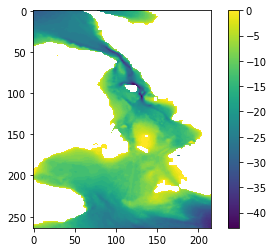

In [11]:
ds = mikeio.read("../tests/testdata/gebco_sound.dfs2")
plt.imshow(ds['Elevation'][0])
plt.colorbar();

In [12]:
ds['Elevation'][0,104,131]

-43.0

This is the processing step.

In [13]:
mikeio.generic.scale("../tests/testdata/gebco_sound.dfs2","gebco_sound_local_datum.dfs2",offset=-2.1)

100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


100%|██████████| 1/1 [00:00<?, ?it/s]


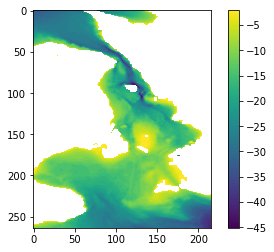

In [14]:
ds2 = mikeio.read("gebco_sound_local_datum.dfs2")
plt.imshow(ds2['Elevation'][0])
plt.colorbar();

In [15]:
ds2['Elevation'][0,104,131]

-45.099998474121094

### Spatially varying correction

In [16]:
import numpy as np
factor = np.ones_like(ds['Elevation'][0])
factor.shape

(264, 216)

Add some spatially varying factors, exaggerated values for educational purpose.

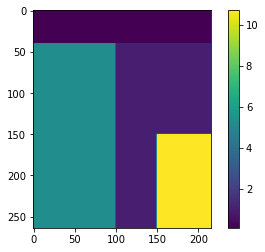

In [17]:
factor[:,0:100] = 5.3
factor[0:40,] = 0.1
factor[150:,150:] = 10.7
plt.imshow(factor)
plt.colorbar();

The 2d array must first be flipped upside down and then converted to a 1d vector using [numpy.ndarray.flatten](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) to match how data is stored in dfs files.

In [18]:
factor_ud = np.flipud(factor)
factor_vec  = factor_ud.flatten()
mikeio.generic.scale("../tests/testdata/gebco_sound.dfs2","gebco_sound_spatial.dfs2",factor=factor_vec)

100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


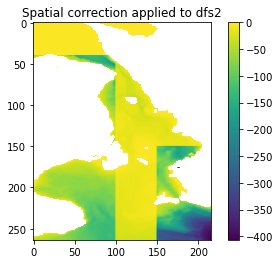

In [19]:
ds3 = mikeio.read("gebco_sound_spatial.dfs2")
plt.imshow(ds3['Elevation'][0])
plt.colorbar()
plt.title("Spatial correction applied to dfs2");

## Clean up

In [20]:
import os
os.remove("concat.dfs1")
os.remove("extracted.dfs1")
os.remove("extracted.dfsu")
os.remove("gebco_sound_local_datum.dfs2")
os.remove("gebco_sound_spatial.dfs2")